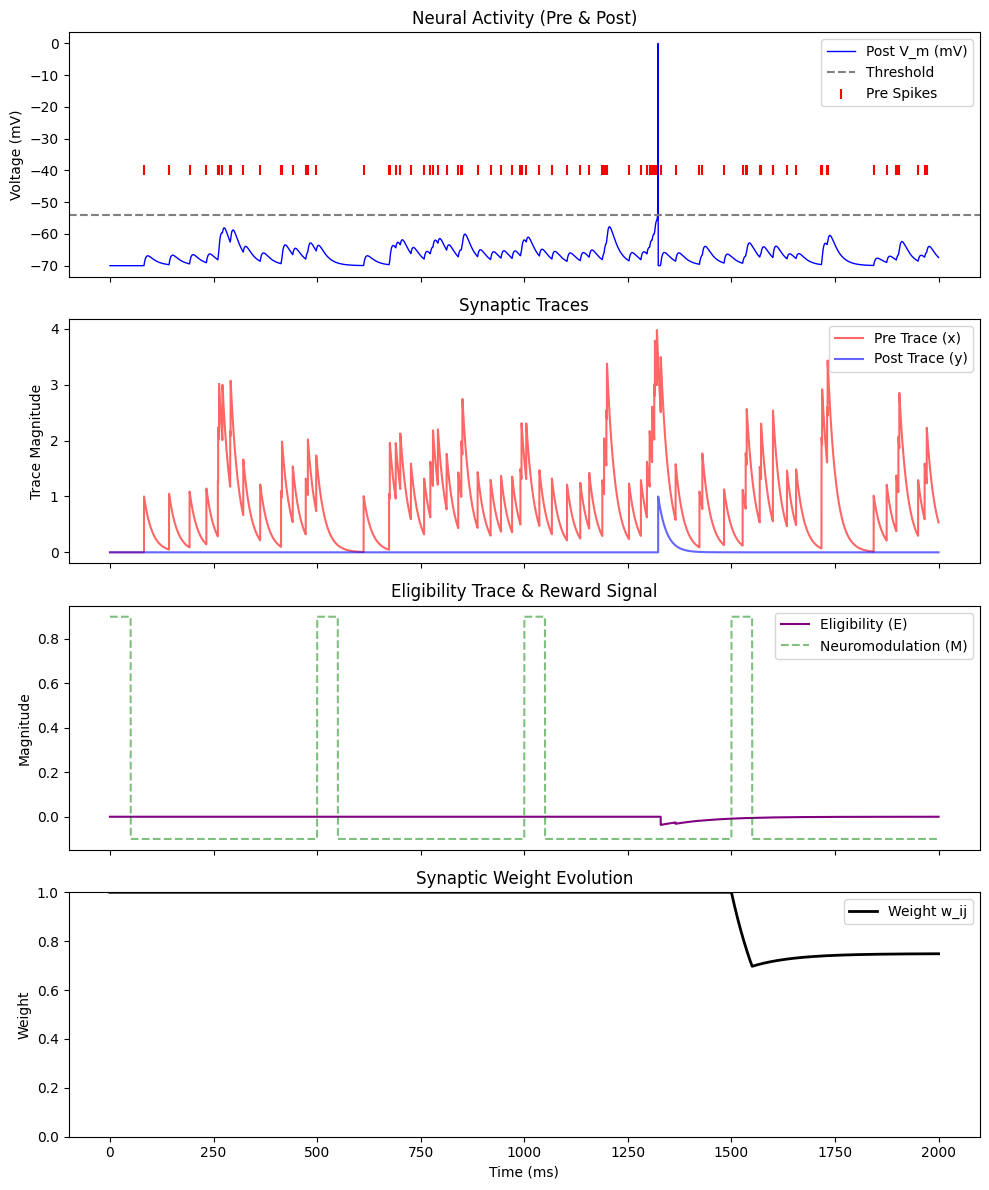

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Simulation Parameters ---
dt = 0.1          # Time step (ms)
T_total = 2000.0  # Total duration (ms)
time = np.arange(0, T_total, dt)
n_steps = len(time)

# Neuron Physics (from text)
tau_m = 20.0      # Membrane time constant (ms)
E_L = -70.0       # Resting potential (mV)
V_reset = -70.0   # Reset potential (mV)
V_thresh = -54.0  # Threshold (mV)
R_m = 20.0        # Membrane resistance (MOhm) - arbitrary scaling
tau_ref = 5.0     # Refractory period (ms)

# Synaptic Dynamics (Eq 2)
tau_s = 5.0       # Synaptic time constant (ms)

# Plasticity / STDP Parameters (Sec 2.2)
tau_plus = 20.0   # Potentiation window (ms)
tau_minus = 20.0  # Depression window (ms)
tau_e = 100.0     # Eligibility trace decay (ms)

# Weight Constraints (Sec 2.4)
w_max = 1.0       # Max weight
w_init = 1.0      # Initial weight
eta_plus = 0.05   # Learning rate LTP
eta_minus = 0.05  # Learning rate LTD

# --- 2. Input Generation ---
# Generate Presynaptic Spikes (Poisson process)
np.random.seed(42)
pre_firing_rate = 0.05 # Probability of spike per ms
pre_spikes = np.random.rand(n_steps) < (pre_firing_rate * dt)

# Generate a synthetic "Reward" signal (M(t))
# We simulate a reward that pulses periodically to demonstrate modulation
reward_signal = np.zeros(n_steps)
# Create a reward pulse every 500ms
for i in range(0, n_steps, int(500/dt)):
    reward_signal[i:i+int(50/dt)] = 1.0 
baseline_reward = 0.1 # R_bar
M = reward_signal - baseline_reward # Eq: M(t) = R(t) - R_bar

# --- 3. Initialization ---
v_post = np.ones(n_steps) * E_L
i_syn = np.zeros(n_steps)     # Synaptic current
w = np.zeros(n_steps)         # Synaptic weight
w[0] = w_init

# Plasticity Traces
x_trace = np.zeros(n_steps)   # Pre-synaptic trace (Eq 5)
y_trace = np.zeros(n_steps)   # Post-synaptic trace (Eq 6)
e_trace = np.zeros(n_steps)   # Eligibility trace (Eq 4)
post_spikes = np.zeros(n_steps, dtype=bool)

# Refractory counter
ref_counter = 0

# --- 4. Simulation Loop ---
for t in range(1, n_steps):
    
    # A. Update Traces (Decay)
    # dx/dt = -x/tau + rho_pre (Simple Euler)
    x_trace[t] = x_trace[t-1] + dt * (-x_trace[t-1] / tau_plus)
    y_trace[t] = y_trace[t-1] + dt * (-y_trace[t-1] / tau_minus)
    
    # If Pre-spike occurs:
    if pre_spikes[t-1]: # Trigger on spike arrival
        x_trace[t] += 1.0
        # Synaptic Current Kick (Eq 2 approximation for discrete time)
        # Weight applied at moment of spike arrival
        i_syn[t-1] += w[t-1] 

    # B. Synaptic Current Decay (Exponential Kernel)
    # dIsyn/dt = -Isyn/tau_s
    i_syn[t] = i_syn[t-1] + dt * (-i_syn[t-1] / tau_s)

    # C. LIF Voltage Dynamics (Eq 1)
    if ref_counter > 0:
        v_post[t] = V_reset
        ref_counter -= 1
    else:
        # dV/dt = -(V - E_L) + R_m * I_syn
        # We assume I_ext is 0 for this demo, or add noise: + np.random.normal(0, 1)
        dv = (-(v_post[t-1] - E_L) + R_m * i_syn[t]) / tau_m
        v_post[t] = v_post[t-1] + dt * dv
        
        # Check Spike Threshold (Eq 3)
        if v_post[t] >= V_thresh:
            v_post[t] = 0 # Spike appearance (optional visualization)
            post_spikes[t] = True
            ref_counter = int(tau_ref / dt)
            y_trace[t] += 1.0 # Update post-trace on spike
            
            # Reset voltage for next step immediately? 
            # Standard LIF resets *after* the spike is recorded.
            # Next step loop will catch the ref_counter.

    # D. Eligibility Trace Calculation (Eq 4 & 7)
    # S_ij = A+ * x * rho_post - A- * y * rho_pre
    
    # Define Soft Bounds Scaling (Sec 2.4)
    A_plus = eta_plus * (w_max - w[t-1])
    A_minus = eta_minus * w[t-1]
    
    S_ij = 0
    # LTP: Pre trace exists + Post spike now
    if post_spikes[t]:
        S_ij += A_plus * x_trace[t]
        
    # LTD: Post trace exists + Pre spike now
    if pre_spikes[t]:
        S_ij -= A_minus * y_trace[t]
        
    # Update Eligibility Trace
    # dE/dt = -E/tau_e + S_ij
    de = (-e_trace[t-1] / tau_e) + (S_ij / dt) # S_ij is impulse-like, scaled by 1/dt effectively in discrete
    e_trace[t] = e_trace[t-1] + dt * de

    # E. Weight Update (Eq 8)
    # dw/dt = M(t) * E(t)
    dw = M[t] * e_trace[t]
    w[t] = w[t-1] + dt * dw
    
    # Clip Weight
    w[t] = np.clip(w[t], 0, w_max)

# --- 5. Visualization ---
fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

# Plot 1: Neural Activity
axs[0].set_title('Neural Activity (Pre & Post)')
axs[0].plot(time, v_post, label='Post V_m (mV)', color='blue', linewidth=1)
axs[0].axhline(V_thresh, color='gray', linestyle='--', label='Threshold')
# Plot spikes as dots
pre_spike_times = time[pre_spikes]
axs[0].scatter(pre_spike_times, np.ones_like(pre_spike_times)*-40, 
               color='red', marker='|', s=50, label='Pre Spikes')
axs[0].legend(loc='upper right')
axs[0].set_ylabel('Voltage (mV)')

# Plot 2: Traces
axs[1].set_title('Synaptic Traces')
axs[1].plot(time, x_trace, label='Pre Trace (x)', color='red', alpha=0.6)
axs[1].plot(time, y_trace, label='Post Trace (y)', color='blue', alpha=0.6)
axs[1].legend(loc='upper right')
axs[1].set_ylabel('Trace Magnitude')

# Plot 3: Eligibility & Reward
axs[2].set_title('Eligibility Trace & Reward Signal')
axs[2].plot(time, e_trace, label='Eligibility (E)', color='purple')
axs[2].plot(time, M, label='Neuromodulation (M)', color='green', linestyle='--', alpha=0.5)
axs[2].legend(loc='upper right')
axs[2].set_ylabel('Magnitude')

# Plot 4: Synaptic Weight
axs[3].set_title('Synaptic Weight Evolution')
axs[3].plot(time, w, label='Weight w_ij', color='black', linewidth=2)
axs[3].set_ylim(0, w_max)
axs[3].set_ylabel('Weight')
axs[3].set_xlabel('Time (ms)')
axs[3].legend()

plt.tight_layout()
plt.show()